# Fitting
To get Korg installed and talking to python, see [the installation documentation](https://ajwheeler.github.io/Korg.jl/stable/install/#Using-Korg-from-Python).

In this notebook, I'll show how to use `Korg.Fit.fit_spectrum` to fit one of the spectra from [Griffith et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221001821G). You will probably find it helpful to look at the [documentation for this function](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.fit_spectrum) as well. For fitting equivalent widths (rather than spectra directly) see [the documentation for `Korg.Fit.ews_to_abundances`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.Fit.ews_to_abundances). This notebook is intended to demonstrate the usages of Korg's fitting functionality, not an ironclad spectral analysis.

_A massive thanks to Emily Griffith for helping to translate this notebook into Python._

In [ ]:
from matplotlib import pyplot as plt
from juliacall import Main as jl
import time
import random
import numpy as np
import pandas as pd

jl.seval("using Korg")
Korg = jl.Korg

[juliapkg] Found dependencies: /Users/sarahkane/miniconda3/julia_env/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /Users/sarahkane/miniconda3/envs/korg/lib/python3.13/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /Users/sarahkane/miniconda3/envs/korg/lib/python3.13/site-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.1, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.4 to /Users/sarahkane/miniconda3/julia_env/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/mac/aarch64/1.11/julia-1

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ProgressMeter ─ v1.10.4
   Installed CondaPkg ────── v0.2.27
    Updating `~/miniconda3/julia_env/Project.toml`
  [acafc109] + Korg v0.44.0
  [6099a3de] + PythonCall v0.9.24
    Updating `~/miniconda3/julia_env/Manifest.toml`
  [47edcb42] + ADTypes v1.14.0
  [621f4979] + AbstractFFTs v1.5.0
  [79e6a3ab] + Adapt v4.3.0
  [66dad0bd] + AliasTables v1.1.3
  [4fba245c] + ArrayInterface v7.18.0
  [13072b0f] + AxisAlgorithms v1.1.0
  [0e736298] + Bessels v0.2.8
  [336ed68f] + CSV v0.10.15
  [d360d2e6] + ChainRulesCore v1.25.1
  [944b1d66] + CodecZlib v0.7.8
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.27
  [187b0558] + ConstructionBase v1.5.8
  [a8cc5b0e] + Crayons v4.1.1
  [717857b8] + DSP v0.8.3
  [9a962f9c] + DataAPI v1.16.0
  [a93c6f00] + DataFrames v1.7.0
  [864edb3b] + DataStructures v0.18.22
  [e2d170a0] + DataValueInterfaces

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Read in the linelist, window list, and spectrum

For this example, we'll use the same linelist and windows as Griffith et al. 2022, which means reading the CSV files they are stored in and getting the data into the format expected by Korg.

In [4]:
# read and parse the linelist used by Griffith et al. 2022
linetable = pd.read_csv("lines.csv");

# filter out the H lines. (Korg has these built-in)
linetable = linetable[linetable.element != "H 1"]

In [5]:
linelist = jl.broadcast(Korg.Line, 
                        jl.broadcast(Korg.air_to_vacuum,linetable.wave_A),
                        linetable.loggf,
                        jl.broadcast(Korg.Species,linetable.element),
                        linetable.lower_state_eV,
                        linetable.rad,
                        linetable.stark,
                        linetable.waals)


In [6]:
# read windows into dictionary that maps atomic number -> window list
windowtable = pd.read_csv("windows.tsv", delimiter='\t');

In [25]:
windowtable

,wave_peak,wave_base,wave_top,species
0,424.6822,424.6522,424.7122,Sc 2
1,432.0732,432.0432,432.1032,Sc 2
2,432.0950,432.0650,432.1250,Ti 2
3,433.1642,433.1342,433.1942,Ni 1
4,433.7046,433.6746,433.7346,Fe 1
...,...,...,...,...
395,625.2555,625.2255,625.2855,Fe 1
396,625.8102,625.7802,625.8402,Ti 1
397,625.8707,625.8407,625.9007,Ti 1
398,626.5132,626.4832,626.5432,Fe 1


In [8]:
windows = {}
for i, row in windowtable.iterrows():
    # atomic number
    Z = Korg.get_atoms(Korg.Species(row.species))[0]
    # get the windows for this element so far 
    wins = windows.get(Z, [])
    # add the new window
    wins.append((Korg.air_to_vacuum(row.wave_base * 10), Korg.air_to_vacuum(row.wave_top * 10)))
    # update the dictionary
    windows[Z] = wins

In [9]:
# parse the observed spectrum
spec = pd.read_csv("2MASS_J03443498+0553014.csv", delimiter="\t")

# juliacall deals better with numpy arrays than pandas series, so we will work with those
flux = np.array(spec.flux)
err = np.array(spec.err)
waveobs = np.array(jl.broadcast(Korg.air_to_vacuum, spec.waveobs * 10))

# Get stellar params with just Fe lines
First, we'll use the Fe windows from `windows.tsv` to fit for the stellar parameters. You may notice that the first time you run this, it takes a minute.  This is because Julia is compiling the function. This happens only once per session. 

In [10]:
# provide an initial guess for each parameter we want to fit
# (This is how to construct a NamedTuple in Julia, by the way.)
initial_guess = dict(Teff=5400, logg=3.8, m_H=-1.1, vmic=1.0)
winds = windows[26] # use Fe windows

# In this example, we'll pass the spectral resolution R and let Korg take care of the line spread function automatically
# Below, I'll show how to speed things up by calculating it ahead of time.
fit_result = Korg.Fit.fit_spectrum(waveobs, flux, err, linelist, initial_guess, windows=winds, R=50_000)
;

Constructing cool dwarf atmosphere interpolator.  This will only happen once per process...


┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


''

`fit_result` is an object containing several bits of info, most importantly the best-fit parameters

In [11]:
fit_result.best_fit_params

Dict{String, Float64} with 4 entries:
  "Teff" => 5261.36
  "logg" => 3.68274
  "m_H"  => -1.33137
  "vmic" => 0.836878

It also contains the trace, which we can plot like so

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9z/9bnj2knn0_x8cbmqntmdhjl40000gn/T/ipykernel_49543/1587999990.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$T_\mathrm{eff}$ [K]")


''

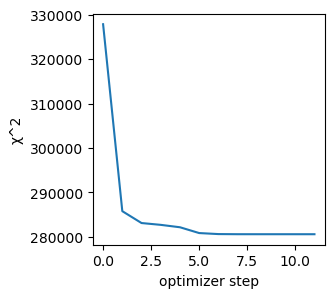

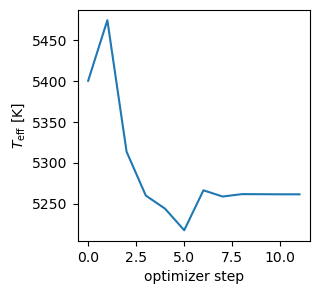

In [12]:
plt.figure(figsize=(3,3))
plt.plot([t["chi2"] for t in fit_result.trace])
plt.ylabel("χ^2")
plt.xlabel("optimizer step")

plt.figure(figsize=(3,3))
plt.plot([t["Teff"] for t in fit_result.trace])
plt.ylabel("$T_\mathrm{eff}$ [K]")
plt.xlabel("optimizer step")
;

The `fit_result` object also contains the best-fit spectrum, which we can plot in comparision to the oberved one.  Rerun the cell below to plot data for different iron lines.

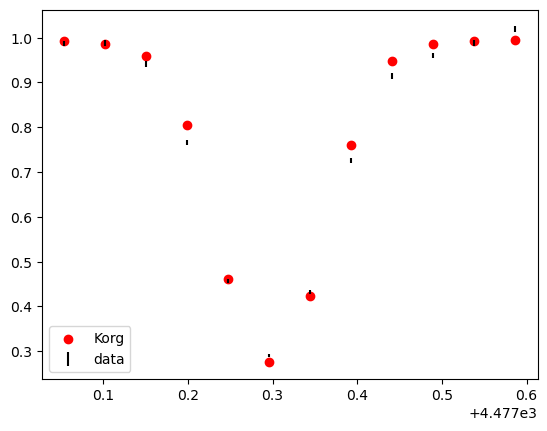

In [13]:
# get the observed spectrum only at the wavelengths within a fitting window
obsmask = np.array(fit_result.obs_wl_mask)
obs_wls = waveobs[obsmask]
obs_flux = flux[obsmask]
obs_err = err[obsmask]

w = random.choice(winds) # choose a window around a random Fe line

# create a bitmask to plot the window plus 1 Å on each side for context
mask = np.array((w[0]-1 < obs_wls) & (obs_wls < w[1]+1))

plt.scatter(obs_wls[mask], np.array(fit_result.best_fit_flux)[mask], c="r", label="Korg")
plt.errorbar(obs_wls[mask], obs_flux[mask], yerr=obs_err[mask], ls="", c="k", label="data")
plt.legend()

# Fit individual abundances

Let's use the stellar parameters from Griffith, rather than the ones from the analysis above. Comparing the abundances you get using each is left as an excercise to the reader.

In [14]:
griffith_params = dict(Teff = 5456, logg = 3.86, m_H = -1.22, vsini = 2.4, vmic=1.23)
print(dict(fit_result.best_fit_params))
print(griffith_params)

{'Teff': 5261.3618310010115, 'logg': 3.6827394699718052, 'm_H': -1.3313660784783279, 'vmic': 0.8368777136521125}
{'Teff': 5456, 'logg': 3.86, 'm_H': -1.22, 'vsini': 2.4, 'vmic': 1.23}


# find individual abundances

In [ ]:
def best_fit_abundance(element):
    print("fitting %s..." % (element))
    
    # use a Dict to store initial guesses at each param instead of a NamedTuple
    params = {element: griffith_params["m_H"]}

    # "params" specifies the initial guesses at the params to fit (in this case a single elemental abundance).
    # griffith_params specifies values which should be fixed (in this case the stellar parameters).
    t = time.process_time()
    fit_result = Korg.Fit.fit_spectrum(waveobs, flux, err, linelist, params, griffith_params, R=50_000, 
                                       windows=windows[Korg.atomic_numbers[element]])
    print(time.process_time() - t, " seconds")

    # return the best-fit abundance
    return fit_result.best_fit_params[element]


In [35]:
elements = ["Na", "Mg", "Si", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni"]
Korg_abunds = [best_fit_abundance(e) for e in elements]

fitting Na...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
4.079882999999995  seconds
fitting Mg...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.0878099999999904  seconds
fitting Si...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.550003000000004  seconds
fitting Ca...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.9154009999999744  seconds
fitting Sc...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.7454369999999813  seconds
fitting Ti...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
5.294091000000037  seconds
fitting V...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.6087349999999674  seconds
fitting Cr...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3.362199999999973  seconds
fitting Mn...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
4.944031999999993  seconds
fitting Fe...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
12.099271000000044  seconds
fitting Co...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (0.0001) will be used as x_abs

3.1971280000000206  seconds
fitting Ni...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
4.258898999999985  seconds


Let's plot these in comparison to the Griffith et al. 2022 abundaces.

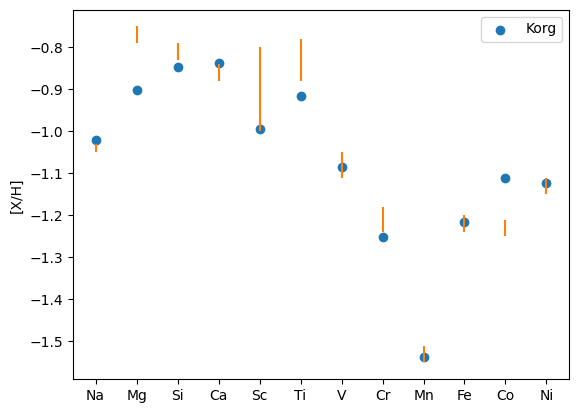

In [17]:
# The are the [X/H] values from the paper (and the errors inferred from Monte-Carlo)
griffith_X_H = [-1.04, -0.77, -0.81, -0.86, -0.9, -0.83, -1.08, -1.21, -1.53, -1.22, -1.23, -1.13]
griffith_X_H_err = [0.01, 0.02, 0.02, 0.02, 0.1, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02]

plt.scatter(range(len(elements)), Korg_abunds, label="Korg")
plt.errorbar(range(len(elements)), griffith_X_H, yerr=griffith_X_H_err, ls="", c="C1")
plt.xticks(range(len(elements)), elements)
plt.ylabel("[X/H]")
plt.legend()
